In [208]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold
from tabulate import tabulate
from sklearn.ensemble import RandomForestRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

font = {'size'   : 14}
matplotlib.rc('font', **font)

In [268]:
data = pd.read_csv('../files/diamonds.txt', sep="\t", header=0)
test_data = data.copy()

In [269]:
test_data = test_data.drop(['price'], axis = 1)

In [270]:
test_data.head()

,cut,color,clarity,depth,table,x,y,z
0,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


In [271]:
test_data.to_csv('test_data.csv', sep="\t")

In [245]:
pwd

'/home/carlywolfbrandt/galvanize/assignments/diamond_dataset/notebooks'

Read in the data and see what we're working with

In [164]:
data.head()

,price,cut,color,clarity,depth,table,x,y,z
0,326,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,326,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,327,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,334,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,335,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


In [9]:
data.tail()

,price,cut,color,clarity,depth,table,x,y,z
39995,2757,Very Good,E,VS2,61.2,59.0,5.69,5.72,3.49
39996,2757,Premium,D,SI1,62.7,59.0,5.69,5.73,3.58
39997,2757,Very Good,D,SI1,62.8,60.0,5.66,5.68,3.56
39998,2757,Premium,H,SI2,61.0,58.0,6.15,6.12,3.74
39999,2757,Ideal,D,SI2,62.2,55.0,5.83,5.87,3.64


In [130]:
data.describe()

,price,depth,table,x,y,z
count,38371.000000,38371.000000,38371.000000,38371.000000,38371.000000,38371.000000
mean,3615.535326,61.756999,57.373902,5.666497,5.669660,3.500247
std,3473.154483,1.267207,2.096092,1.068537,1.061034,0.660391
min,326.000000,57.500000,51.000000,3.730000,3.710000,1.530000
25%,928.000000,61.100000,56.000000,4.690000,4.700000,2.890000
50%,2316.000000,61.800000,57.000000,5.660000,5.670000,3.500000
75%,5080.000000,62.500000,59.000000,6.490000,6.490000,4.020000
max,15873.000000,66.000000,64.000000,9.080000,9.010000,5.650000


Let's make a scatter matrix plot to visualize how these variables interact

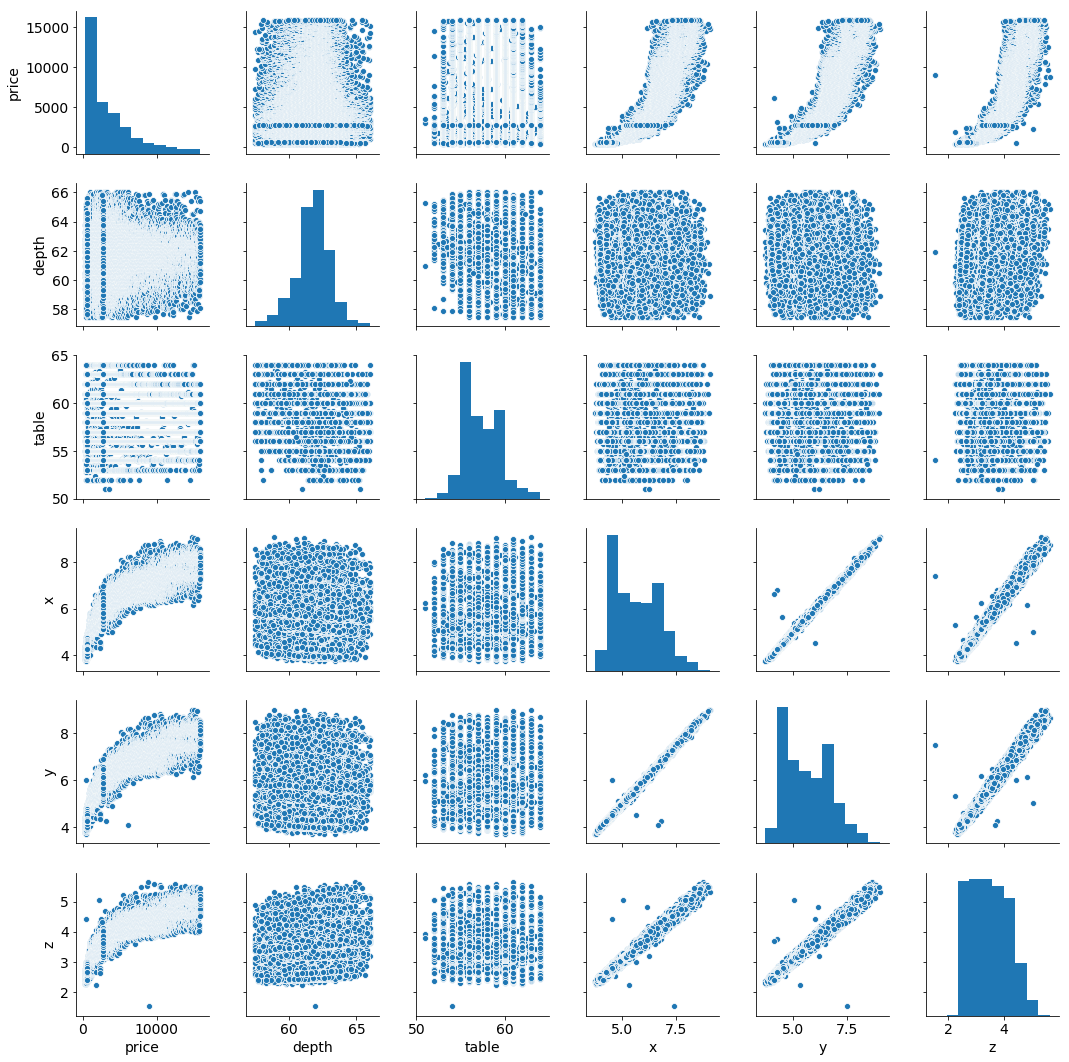

In [102]:
sns.pairplot(data)

There are some weird data points in here, particularly where z > 30 and y > 30. It looks like it's just two rows, so maybe we can drop it

In [11]:
data_coords = data[(data['y']>30) | (data['z']>30)]
data_coords.head()

,price,cut,color,clarity,depth,table,x,y,z
35904,1970,Very Good,E,VS1,61.8,54.7,5.12,5.15,31.80
36493,2075,Ideal,E,VS1,61.8,55.0,5.15,31.80,5.12


Yep, only 2 rows. Since I am going to replace the values where x,y and z == 0 with their respective means, I am going to drop these two so they don't skew the mean to be artificially high.

In [12]:
data = data.loc[~((data.['y'] > 20) | (data['z'] > 20))]

In [13]:
data.loc[(data['y']>20) | (data['z']>20)].count()

price      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

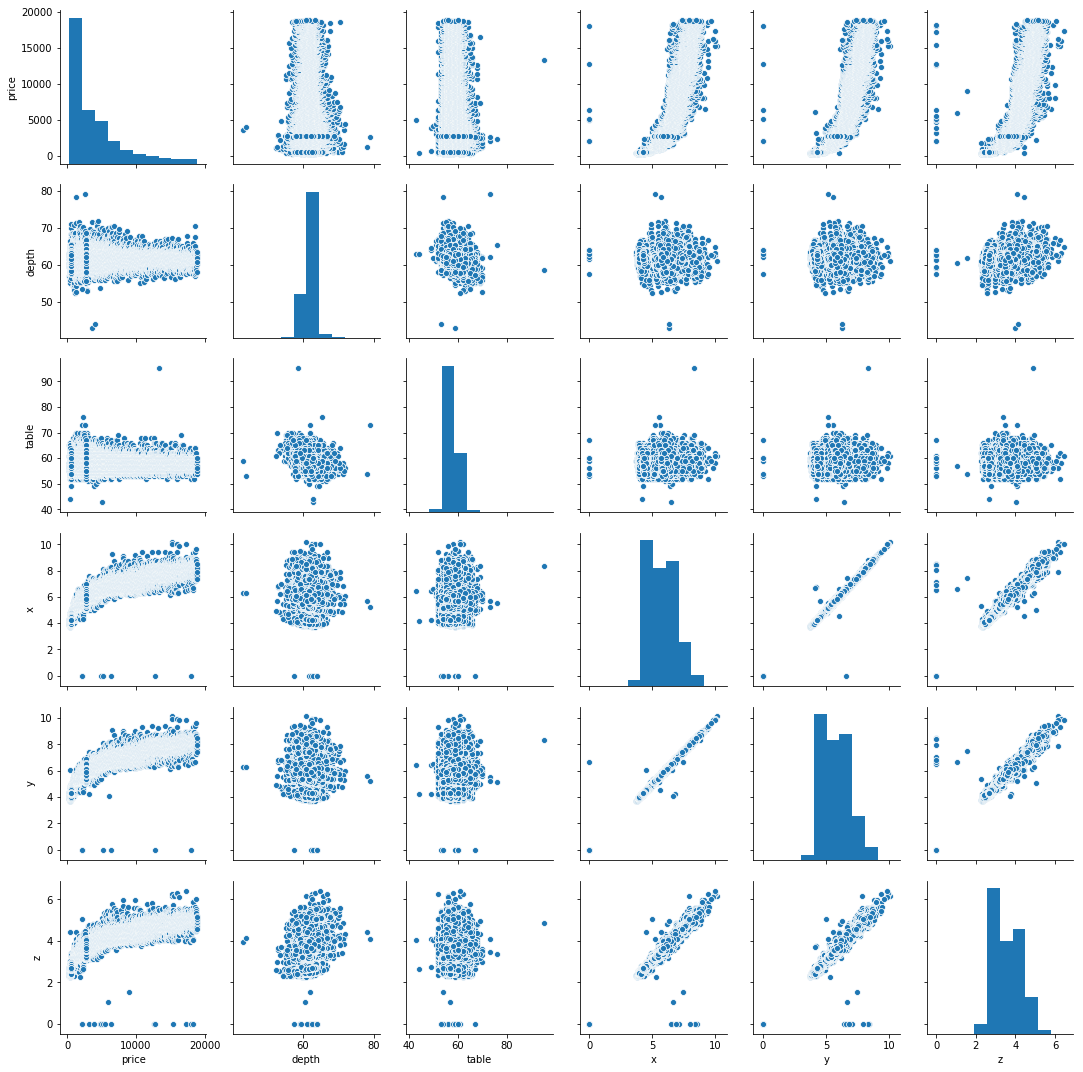

In [10]:
sns.pairplot(data)

Looking better. Now to deal with those pesky 0's in the x, y and z columns. These are obviously bad data points, since a diamond needs 3 dimensions in order to exist.

In [14]:
data.describe()

,price,depth,table,x,y,z
count,39998.000000,39998.000000,39998.000000,39998.000000,39998.000000,39998.000000
mean,3927.111356,61.753703,57.460971,5.729214,5.731107,3.537385
std,3982.303243,1.430041,2.234599,1.121145,1.112574,0.694795
min,326.000000,43.000000,43.000000,0.000000,0.000000,0.000000
25%,949.000000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,2401.000000,61.800000,57.000000,5.700000,5.710000,3.520000
75%,5313.750000,62.500000,59.000000,6.540000,6.540000,4.030000
max,18823.000000,79.000000,95.000000,10.140000,10.100000,6.430000


In [91]:
zero_coords = data[(data['x']==0) | (data['y']==0) | (data['z']==0)]
zero_coords

,price,cut,color,clarity,depth,table,x,y,z
1640,3142,Premium,G,SI2,59.1,59.0,6.55,6.48,0.0
4054,3837,Premium,F,SI2,59.2,58.0,6.50,6.47,0.0
7560,4731,Good,G,I1,64.0,61.0,7.15,7.04,0.0
8318,4954,Ideal,F,SI2,61.6,56.0,0.00,6.62,0.0
8901,5139,Very Good,H,VS2,63.3,53.0,0.00,0.00,0.0
10113,5564,Ideal,G,VS2,59.2,56.0,6.88,6.83,0.0
11881,6381,Fair,G,VS1,57.5,67.0,0.00,0.00,0.0
18133,12631,Premium,H,SI2,59.4,61.0,8.49,8.45,0.0
18229,12800,Ideal,G,VS2,62.2,54.0,0.00,0.00,0.0
19411,15397,Premium,I,SI1,61.3,58.0,8.52,8.42,0.0


I am going to replace these with the means for each column.

In [94]:
data.loc[:,['x','y','z']] = data[['x','y','z']].replace(0,np.nan).fillna(data[['x','y','z']].mean())

# data.loc[data.x == 0, 'x'] = data['x'].mean()
# data.loc[data.y == 0, 'y'] = data['y'].mean()
# data.loc[data.z == 0, 'z'] = data['z'].mean()

In [95]:
data.loc[(data['x']==0) | (data['y']==0) | (data['z']==0)].count()

price      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

In [18]:
data.describe()

,price,depth,table,x,y,z
count,39998.000000,39998.000000,39998.000000,39998.000000,39998.000000,39998.000000
mean,3927.111356,61.753703,57.460971,5.730217,5.731966,3.538712
std,3982.303243,1.430041,2.234599,1.118580,1.110357,0.691408
min,326.000000,43.000000,43.000000,3.730000,3.710000,1.070000
25%,949.000000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,2401.000000,61.800000,57.000000,5.700000,5.710000,3.530000
75%,5313.750000,62.500000,59.000000,6.540000,6.540000,4.030000
max,18823.000000,79.000000,95.000000,10.140000,10.100000,6.430000


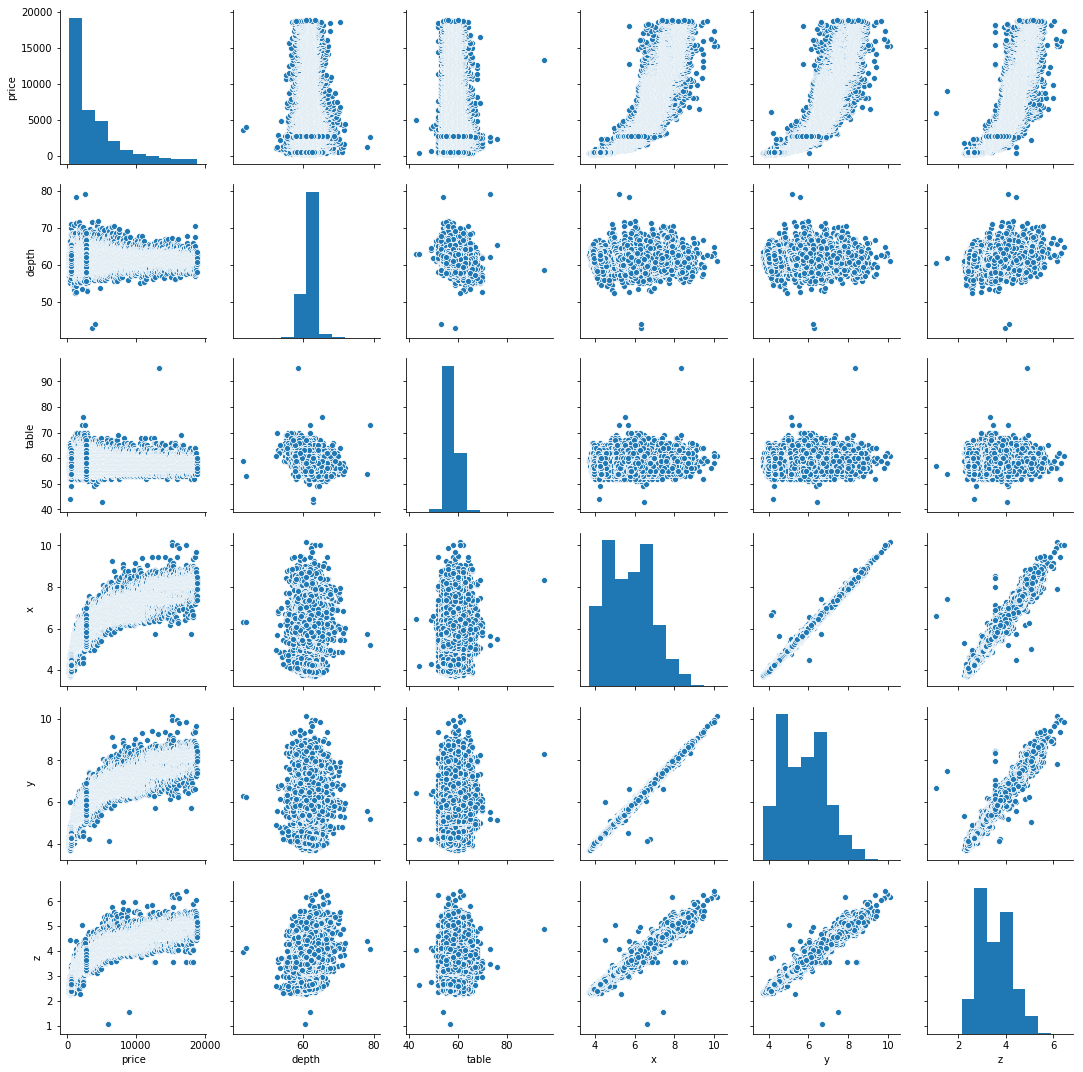

In [16]:
sns.pairplot(data)

Now we are getting somewhere. The only other data point that stands out to me as peculiar is the table > 80. I am going to drop that bad boy as well.

In [19]:
data = data.loc[~(data['table'] > 80)]

Let's productionize this so we don't have to manually look for outliers. The following code will only keep rows where all values are within 3 standard deviations from the mean.

In [165]:
outlier_mask = (np.abs(stats.zscore(data.select_dtypes(include=np.number)))<3).all(axis=1)
data = data[outlier_mask]
data.describe()

,price,depth,table,x,y,z
count,38371.000000,38371.000000,38371.000000,38371.000000,38371.000000,38371.000000
mean,3615.535326,61.756999,57.373902,5.666497,5.669660,3.500247
std,3473.154483,1.267207,2.096092,1.068537,1.061034,0.660391
min,326.000000,57.500000,51.000000,3.730000,3.710000,1.530000
25%,928.000000,61.100000,56.000000,4.690000,4.700000,2.890000
50%,2316.000000,61.800000,57.000000,5.660000,5.670000,3.500000
75%,5080.000000,62.500000,59.000000,6.490000,6.490000,4.020000
max,15873.000000,66.000000,64.000000,9.080000,9.010000,5.650000


In [166]:
print(tabulate(data.describe(), headers='keys', tablefmt="pipe"))

|       |    price |       depth |       table |           x |           y |            z |
|:------|---------:|------------:|------------:|------------:|------------:|-------------:|
| count | 38371    | 38371       | 38371       | 38371       | 38371       | 38371        |
| mean  |  3615.54 |    61.757   |    57.3739  |     5.6665  |     5.66966 |     3.50025  |
| std   |  3473.15 |     1.26721 |     2.09609 |     1.06854 |     1.06103 |     0.660391 |
| min   |   326    |    57.5     |    51       |     3.73    |     3.71    |     1.53     |
| 25%   |   928    |    61.1     |    56       |     4.69    |     4.7     |     2.89     |
| 50%   |  2316    |    61.8     |    57       |     5.66    |     5.67    |     3.5      |
| 75%   |  5080    |    62.5     |    59       |     6.49    |     6.49    |     4.02     |
| max   | 15873    |    66       |    64       |     9.08    |     9.01    |     5.65     |


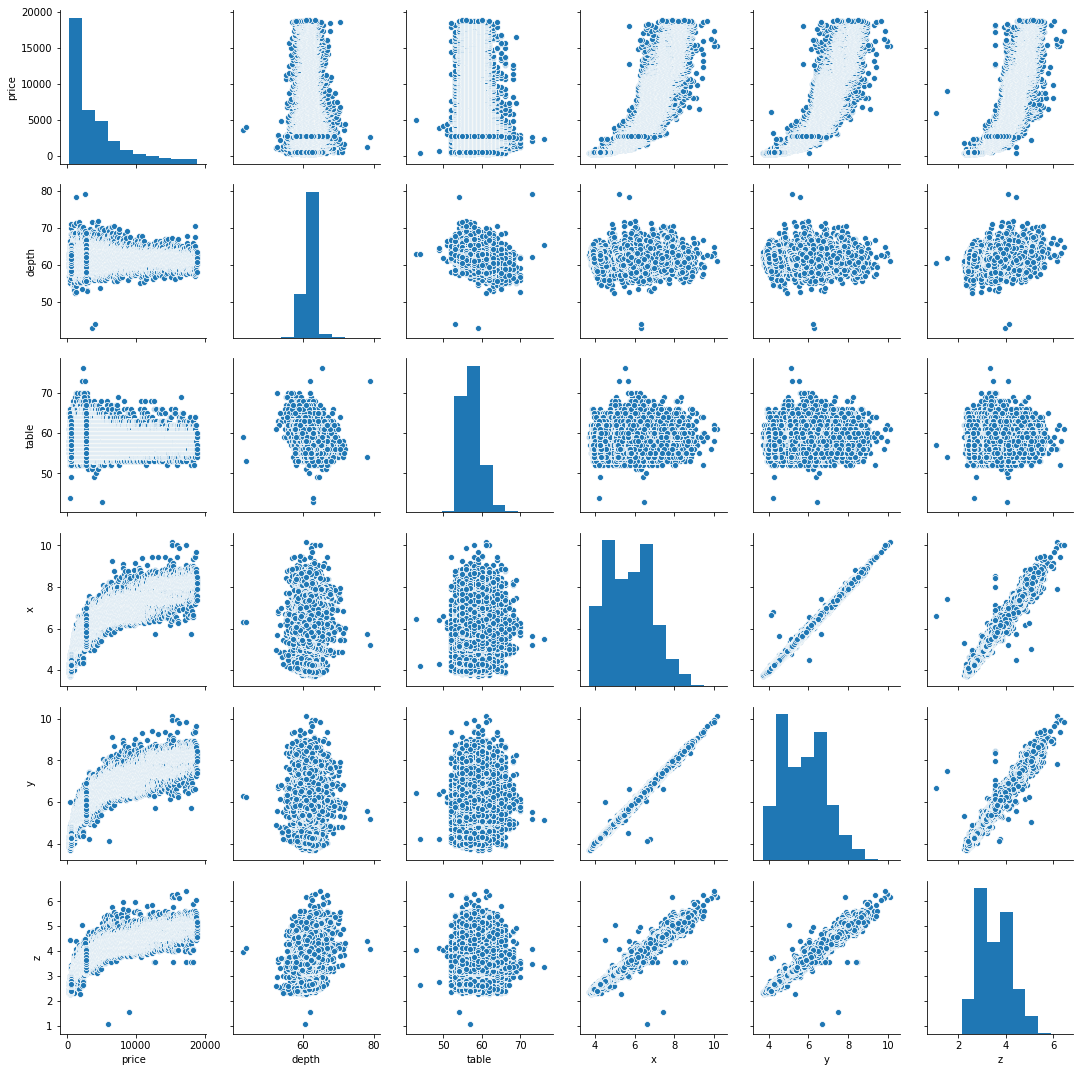

In [20]:
sns.pairplot(data)

In [168]:
data['clarity'] = data['clarity'].map({'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8})
data['cut'] = data['cut'].map({'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5})
data['color'] = data['color'].map({'D': 7, 'E': 6, 'F': 5, 'G': 4, 'H': 3, 'I': 2, 'J': 1})

In [142]:
data['log_volume']= np.log(data['x'] * data['y'] * data['z'])

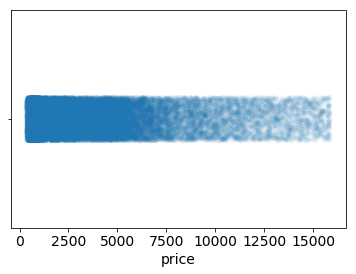

In [181]:
sns.stripplot(x = 'price', data=data, alpha = 0.05)

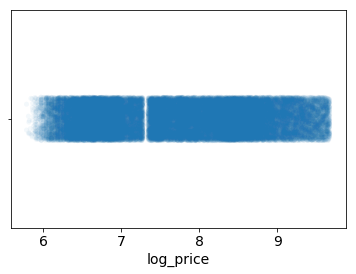

In [187]:
sns.stripplot(x = 'log_price', data=data, alpha = 0.05)

In [175]:
data['log_price']= np.log(data['price'])

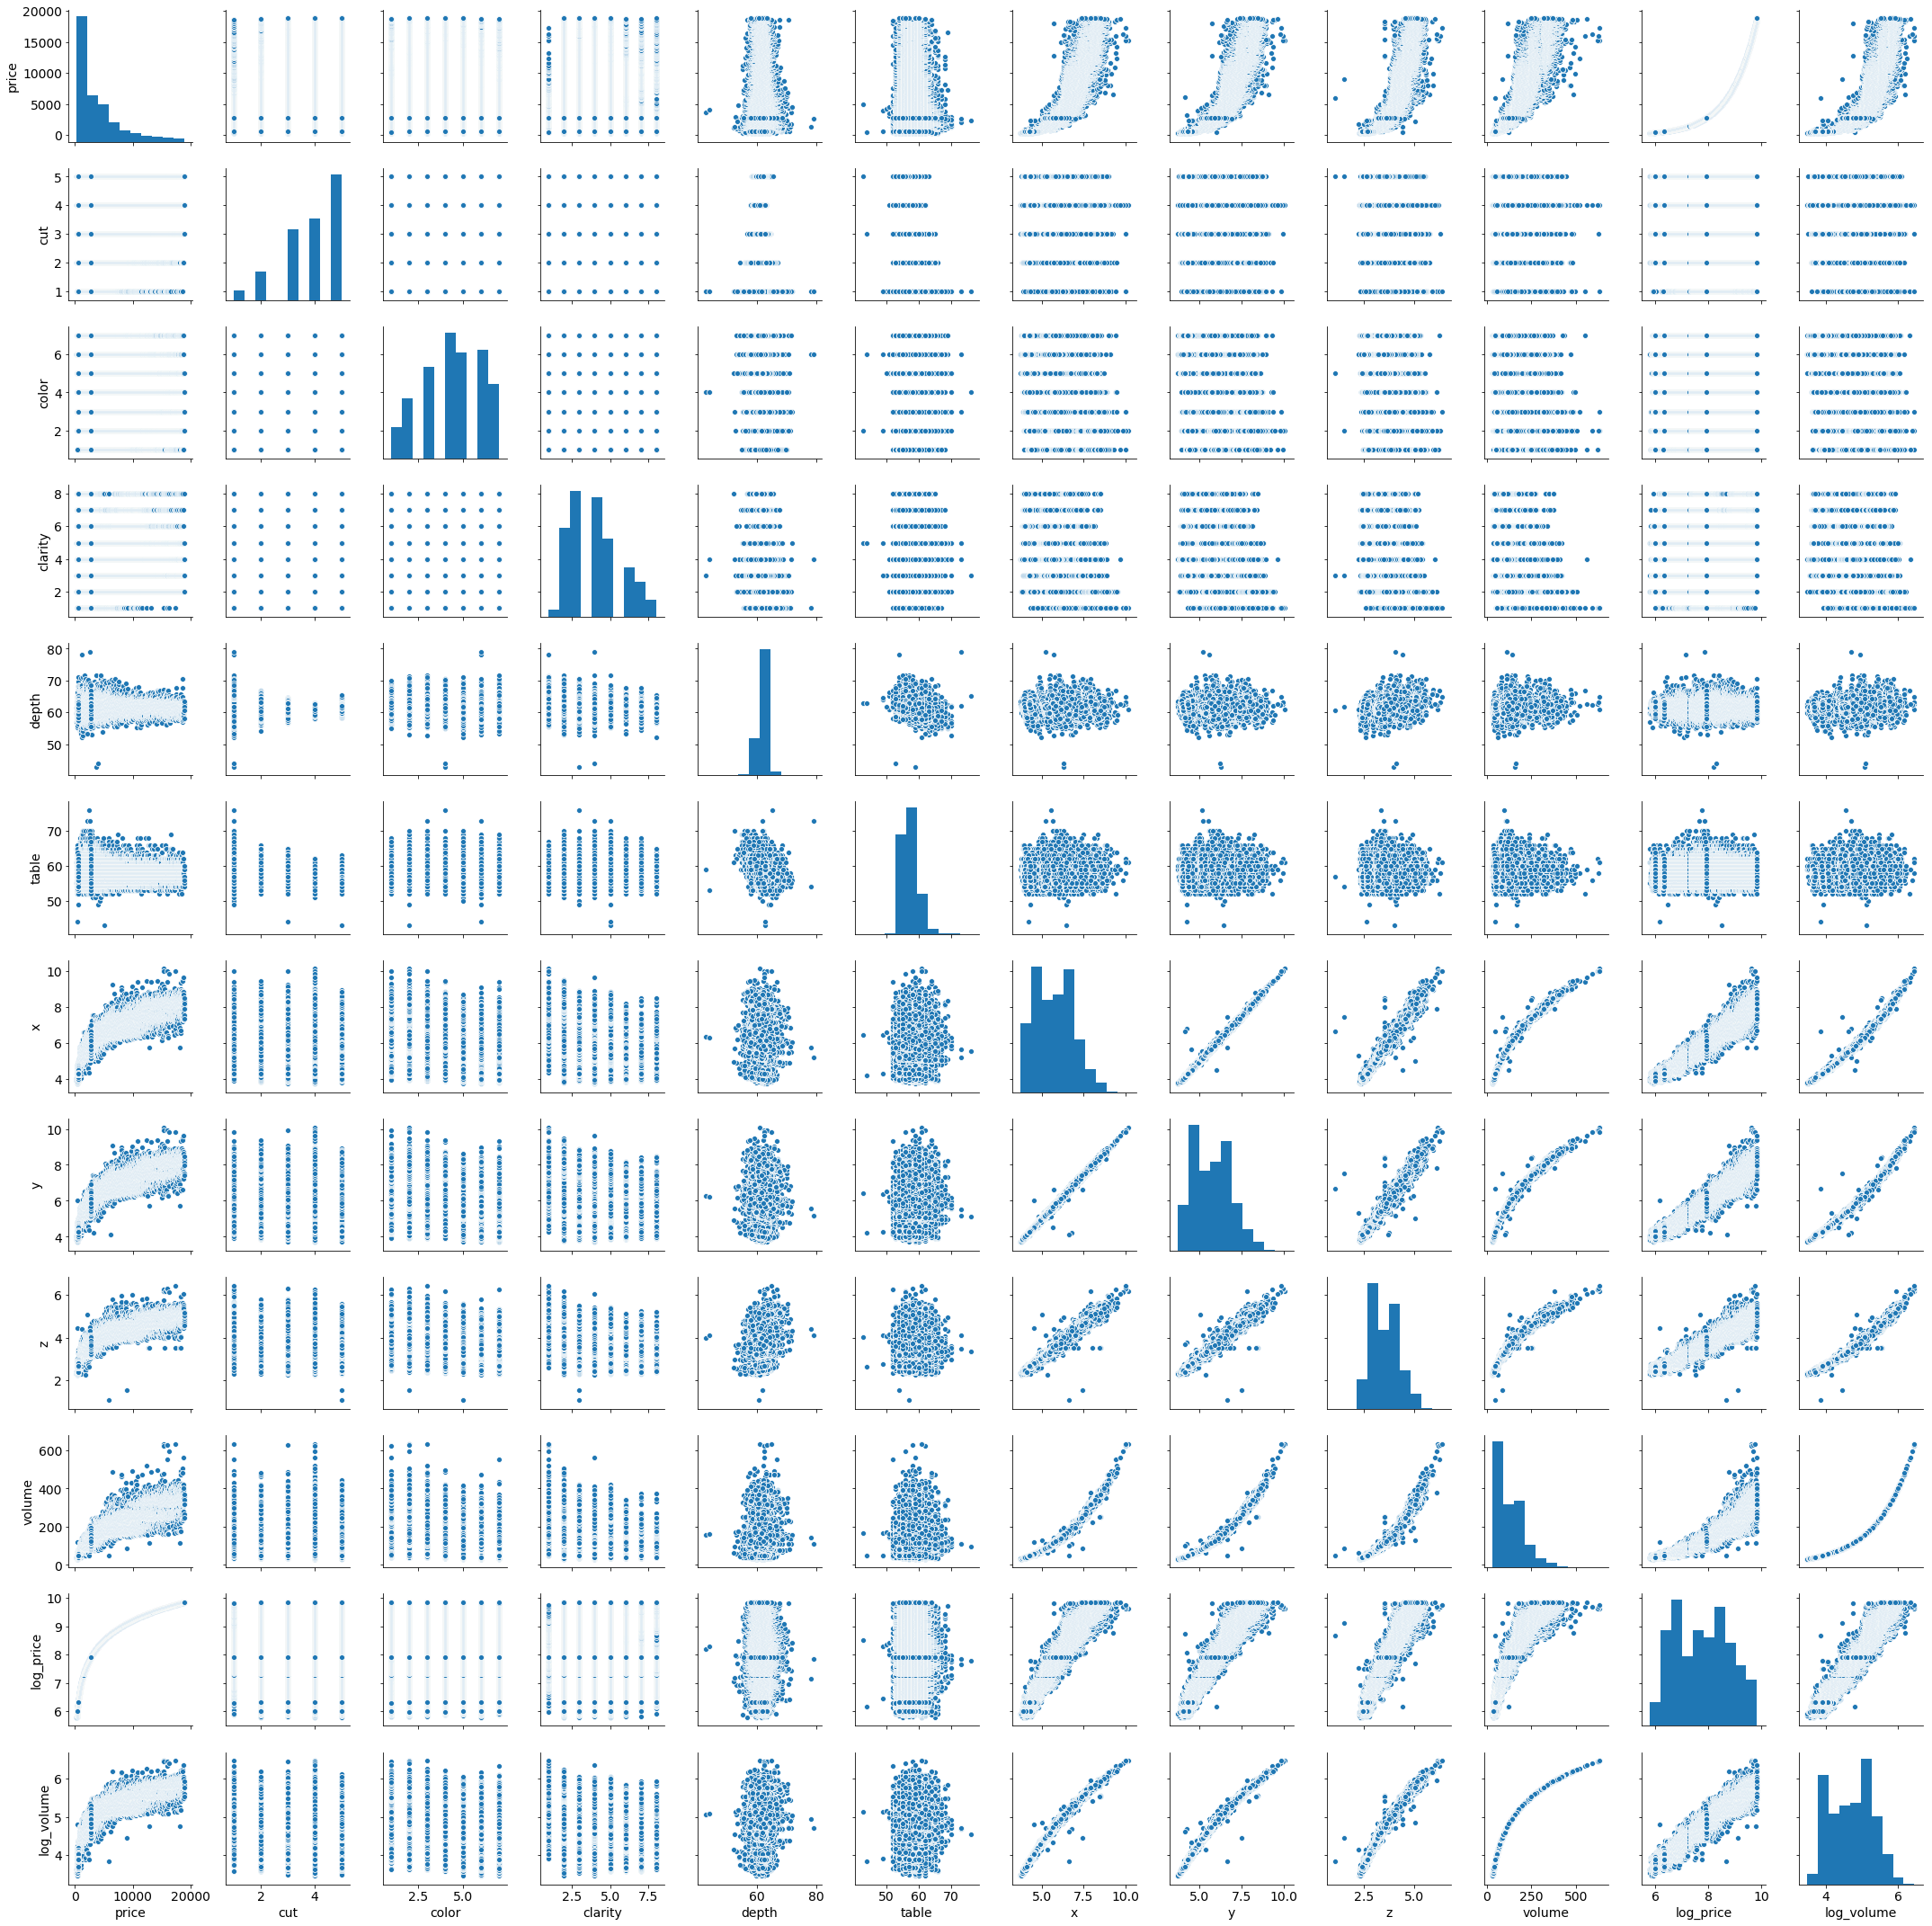

In [85]:
sns.pairplot(data)

In [150]:
def summary_model(X_train, y_train, label='scatter'):
    X = sm.add_constant(X_train)
    model = sm.OLS(y_train, X).fit()
    summary = model.summary()
    return summary

def predict_model(X_train, y_train, X_test, y_test, label='Prediction vs. True'):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    model = sm.OLS(y_train, X_train).fit()
    predictions = model.predict(X_test)

    plt.scatter(y_test, predictions, label=label)
    plt.legend()
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

def plot_model(X, y, label='Residual Plot'):
    X = sm.add_constant(X_train)
    model = sm.OLS(y, X).fit()
    student_resids = model.outlier_test()['student_resid']
    y_hats = model.predict(X)

    plt.scatter(y_hats, student_resids, alpha = .15, label=label)
    plt.legend()
    plt.show()

In [151]:
data_model = data[['log_price','color','cut','clarity','log_volume','table']]

X = data_model.copy()
y = X.pop('log_price')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 101)

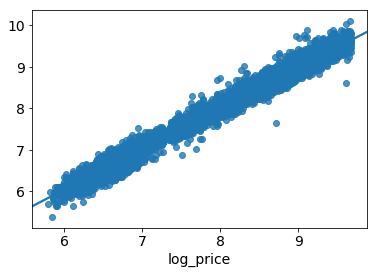

In [242]:
lm = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=-2)
lm.fit(X_train,y_train)
y_predicted = lm.predict(X_test)
sns.regplot(y_test, y_predicted)

In [241]:
coeffs = pd.DataFrame(lm.coef_)
coeffs.index = X_train.columns
coeffs.rename({0:'value'}, axis = 1, inplace = True)
coeffs = coeffs.sort_values(by = ['value'], ascending = False)
coeffs

,value
log_volume,1.886348
clarity,0.119566
color,0.076638
cut,0.019520
table,0.003977


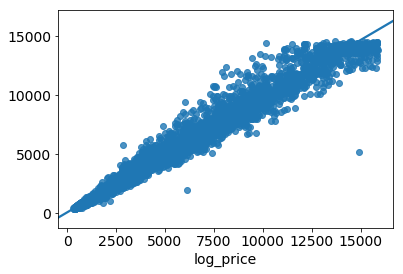

In [212]:
rf = RandomForestRegressor(n_estimators=200, max_depth=10, n_jobs=-2)
rf.fit(X_train,y_train)
y_predicted = rf.predict(X_test)
sns.regplot(np.exp(y_test), np.exp(y_predicted))

In [240]:
feat = pd.DataFrame(rf.feature_importances_)
feat.index = X_train.columns
feat.rename({0:'feature_importance'}, axis = 1, inplace = True)
feat = feat.sort_values(by = 'feature_importance', ascending = False)
feat

,feature_importance
log_volume,0.951494
clarity,0.032281
color,0.014747
cut,0.001061
table,0.000416


In [78]:
coeffs = pd.DataFrame(ridge.coef_)
coeffs.index = X_train.columns
coeffs.rename({0:'value'}, axis = 1, inplace = True)
coeffs.sort_values(by = 'value', ascending = False)

,value
log_volume,1.410627
clarity,0.046916
color,0.026579
cut,0.016901
table,0.012983
depth,0.004552


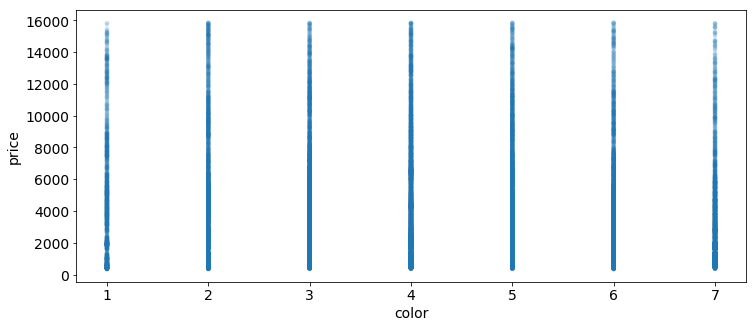

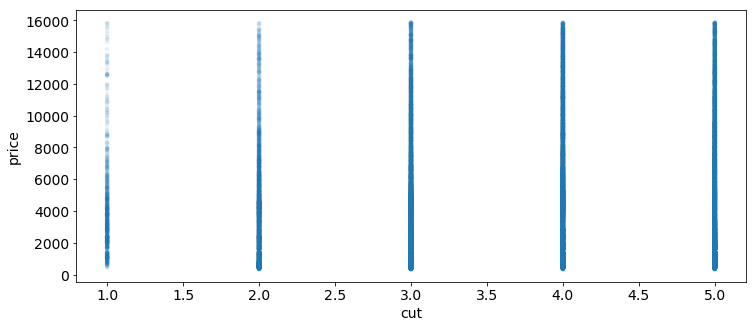

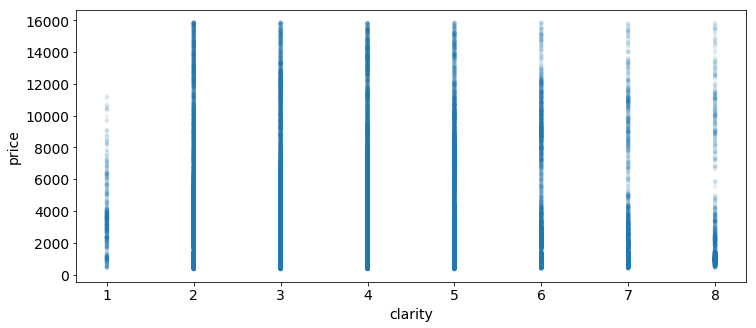

KeyError: 'log_volume'

In [243]:
all_columns = X.columns
for col in all_columns:
    data.plot(kind='scatter', y='price', x=col, edgecolor='none', figsize=(12, 5), alpha = 0.1)
    plt.xlabel(col)
    plt.ylabel('price')
    plt.show()

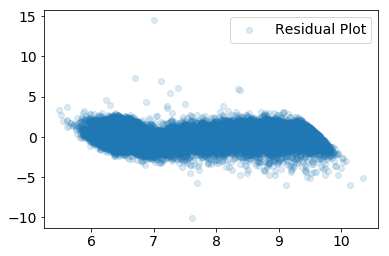

AttributeError: 'NoneType' object has no attribute 'get_figure'

In [155]:
svm = plot_model(X_train, y_train, label='Residual Plot')
figure = svm.get_figure()    
figure.savefig('stud_resid_log.png', dpi=400)
svm